# **Disentangled Representational Learning of Single Lead Electrocardiogram Signals using Variational Autoencoder**

This notebook evaluates the properties and accuracy of the trained VECG model in several aspects. The structure follows the three main objectives:

1. investigation of **Disentanglement**
2. evaluation of **Anomaly Detection** accuracy and explainability
3. improvements through the use of **Personalization**

The results are summarized in a corresponding article, which the authors ask to be cited when using the results of this work.

## General

This section of for imports, getting an overview of all experiments, and loading the most suitable model.

In [1]:
import sys
import os
import warnings
import logging
from absl import logging as absl_logging
import json
import tensorflow as tf

# ✅ Ensure Correct TensorFlow Configuration
os.environ['TFDS_DATA_DIR'] = r"/data/newc6477/VAE/Single_Beat/15_percent_Physionet/"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# ✅ Ensure Correct Working Directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print(f"📂 Project Root: {PROJECT_ROOT}")

# ✅ Ensure `src/` is in Python's Path
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print(f"✅ Updated sys.path:\n{sys.path}")

# ✅ Suppress Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
absl_logging.set_verbosity(absl_logging.ERROR)

# ✅ Import Modules
try:
    from src.utils.helper import Helper
    from src.evaluate.visualizations import Visualizations
    print("✅ Successfully imported `Helper` and `Visualizations`")
except ModuleNotFoundError as e:
    print(f"❌ Import Error: {e}")
    print("🔍 Check if `src/` has `__init__.py` and is in `sys.path`.")

# ✅ Import Other Required Libraries
import pandas as pd
import numpy as np
import glob
from neurokit2.signal import signal_smooth

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns



2025-04-05 16:27:27.653374: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 16:27:27.659114: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 16:27:27.699660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-05 16:27:27.699704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-05 16:27:27.699732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

📂 Project Root: /users/newc6477/VAE/12_Lead_VECG
✅ Updated sys.path:
['/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python310.zip', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/lib-dynload', '', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/site-packages', '/users/newc6477/Benchmark_ISIBrno/ENTER/envs/my_env/lib/python3.10/site-packages/setuptools/_vendor', '/users/newc6477/VAE/12_Lead_VECG', '/users/newc6477/VAE/12_Lead_VECG/src']
✅ Successfully imported `Helper` and `Visualizations`


In [2]:
# The resolution for saving images
DPI = 300

# The source path of the experiments and models
PATH = r"/users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1"

# Some operations take some time in computation.
# Therefore, the stored intermediate results can be used to skip the respective computation.
USE_PRECOMPUTED = True

Whenever a dataset is used within this work, e.g., for loading or embedding, it needs to be declared as a dictionary. The keys are a name (array of datasets to be loaded), the split, the shuffle size, and the batch size.

In [4]:
BASE = '/users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1'

# Path to the JSON file containing best timestamps for each lead
json_path = "best_folders.json"

# Load best folder names from JSON
with open(json_path, "r") as f:
    best_folders = json.load(f)

# Load models dynamically into a dictionary
models = {}
for lead_key, folder in best_folders.items():
    # Strip "lead_" prefix → "lead_I" → "I"
    lead = lead_key.replace("lead_", "")
    
    model_path = os.path.join(BASE, lead, folder, "model_best.keras")
    if os.path.exists(model_path):
        print(f"✅ Loading model for {lead} from {model_path}")
        models[lead] = tf.keras.models.load_model(model_path, compile=False)
    else:
        print(f"❌ Warning: Model not found for {lead} at {model_path}")


# If needed, convert to a list
model_list = list(models.values())


✅ Loading model for I from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/I/2025-04-02_22-42-54/model_best.keras
✅ Loading model for II from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/II/2025-04-03_02-02-15/model_best.keras
✅ Loading model for III from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/III/2025-04-03_07-36-41/model_best.keras
✅ Loading model for aVR from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/aVR/2025-04-03_11-04-51/model_best.keras
✅ Loading model for aVF from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/aVF/2025-04-03_15-57-48/model_best.keras
✅ Loading model for V1 from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/V1/2025-04-03_21-35-05/model_best.keras
✅ Loading model for V2 from /users/newc6477/VAE/12_Lead_VECG/results/full_15/test_is_split1/V2/2025-04-03_14-48-29/model_best.keras
✅ Loading model for V3 from /users/newc6477/VAE/12_Lead_VECG/results/ful

In [7]:
train_splits = ['split2', 'split3', 'split4', 'split5']
dataset_config = {
    'name': ['physionet'],
    'split': train_splits,
    'shuffle_size': 1024,
    'batch_size': 1024,
}
test_splits = ['split1']
dataset_test = {
    'name': ['physionet'],
    'split': test_splits,
    'shuffle_size': 1024,
    'batch_size': 1024,
}

In [8]:
df_physionet_train, ld = Helper.get_embeddings(models, dataset_config)
#df_physionet_validation, _ = Helper.get_embeddings(model, dataset_physionet_validation)
df_physionet_test, _ = Helper.get_embeddings(models, dataset_test)

df_physionet_train = df_physionet_train[0]
#df_physionet_validation = df_physionet_validation[0]
df_physionet_test = df_physionet_test[0]
print(type(df_physionet_train))



📦 Loading dataset: physionet
  ⤷ Using splits: ['split2', 'split3', 'split4', 'split5']
🔍 Processing lead I...


AttributeError: 'str' object has no attribute '_encoder'

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Prepare feature matrix and labels
X_train = df_physionet_train.iloc[:, :ld].values  
X_test = df_physionet_test.iloc[:, :ld].values  
y_train = np.array(df_physionet_train['diagnostic'].tolist(), dtype=int)  
y_test = np.array(df_physionet_test['diagnostic'].tolist(), dtype=int)  

# Define KNN model
knn = KNeighborsClassifier()

# Wrap it inside MultiOutputClassifier
multi_label_knn = MultiOutputClassifier(knn, n_jobs=-1)

# Define Grid Search parameters for 'k'
param_grid = {
    "estimator__n_neighbors": [3, 5, 7, 9, 11]  # Testing different values of k
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    multi_label_knn, param_grid, scoring="accuracy", cv=5, n_jobs=-1
)

# Perform the Grid Search
print("🔍 Performing Grid Search...")
grid_search.fit(X_train, y_train)

# Best hyperparameter
print("✅ Best k found:", grid_search.best_params_)

# Use the best model
best_knn = grid_search.best_estimator_

# Predict using the best model
y_pred = best_knn.predict(X_test)



🔍 Performing Grid Search...
✅ Best k found: {'estimator__n_neighbors': 3}


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Calculate accuracy for each label separately
accuracy_per_label = (y_pred == y_test).mean(axis=0)

# Calculate overall accuracy (percentage of completely correct multi-label predictions)
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute F1-score (macro & micro average)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")

# Generate classification report
class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(y_test.shape[1])])

# Print evaluation metrics
print("✅ Overall Accuracy:", overall_accuracy)
print("✅ F1 Score (Macro):", f1_macro)
print("✅ F1 Score (Micro):", f1_micro)
print("✅ Classification Report:\n", class_report)

✅ Overall Accuracy: 0.28701067615658366
✅ F1 Score (Macro): 0.18481069405830997
✅ F1 Score (Micro): 0.38977989160491094
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.21      0.27       791
           1       0.44      0.35      0.39      1155
           2       0.04      0.00      0.01       272
           3       0.00      0.00      0.00         6
           4       0.38      0.12      0.18       124
           5       0.67      0.53      0.60       580
           6       0.26      0.13      0.18       319
           7       0.03      0.02      0.02       186
           8       0.31      0.30      0.30       740
           9       0.29      0.18      0.22       249
          10       0.00      0.00      0.00        30
          11       0.03      0.01      0.01       208
          12       0.03      0.01      0.02       222
          13       0.00      0.00      0.00       128
          14       0.53      0.56      0.55

🚀 Starting training...


Epochs:   7%|▋         | 1/15 [00:02<00:32,  2.35s/it]

📉 Epoch 1/15 - Train Loss: 0.1199 | Val Loss: 0.0866


Epochs:  13%|█▎        | 2/15 [00:04<00:30,  2.35s/it]

📉 Epoch 2/15 - Train Loss: 0.0770 | Val Loss: 0.0735


Epochs:  20%|██        | 3/15 [00:07<00:28,  2.34s/it]

📉 Epoch 3/15 - Train Loss: 0.0631 | Val Loss: 0.0654


Epochs:  27%|██▋       | 4/15 [00:09<00:25,  2.34s/it]

📉 Epoch 4/15 - Train Loss: 0.0529 | Val Loss: 0.0591


Epochs:  33%|███▎      | 5/15 [00:11<00:23,  2.34s/it]

📉 Epoch 5/15 - Train Loss: 0.0453 | Val Loss: 0.0562


Epochs:  40%|████      | 6/15 [00:14<00:21,  2.34s/it]

📉 Epoch 6/15 - Train Loss: 0.0396 | Val Loss: 0.0536


Epochs:  47%|████▋     | 7/15 [00:16<00:18,  2.34s/it]

📉 Epoch 7/15 - Train Loss: 0.0351 | Val Loss: 0.0530


Epochs:  53%|█████▎    | 8/15 [00:18<00:16,  2.34s/it]

📉 Epoch 8/15 - Train Loss: 0.0314 | Val Loss: 0.0528


Epochs:  60%|██████    | 9/15 [00:21<00:14,  2.34s/it]

📉 Epoch 9/15 - Train Loss: 0.0282 | Val Loss: 0.0533


Epochs:  67%|██████▋   | 10/15 [00:23<00:11,  2.34s/it]

📉 Epoch 10/15 - Train Loss: 0.0256 | Val Loss: 0.0517


Epochs:  73%|███████▎  | 11/15 [00:25<00:09,  2.34s/it]

📉 Epoch 11/15 - Train Loss: 0.0233 | Val Loss: 0.0529


Epochs:  80%|████████  | 12/15 [00:28<00:07,  2.34s/it]

📉 Epoch 12/15 - Train Loss: 0.0214 | Val Loss: 0.0530


Epochs:  87%|████████▋ | 13/15 [00:30<00:04,  2.34s/it]

📉 Epoch 13/15 - Train Loss: 0.0193 | Val Loss: 0.0550


Epochs:  93%|█████████▎| 14/15 [00:32<00:02,  2.33s/it]

📉 Epoch 14/15 - Train Loss: 0.0177 | Val Loss: 0.0561


Epochs: 100%|██████████| 15/15 [00:35<00:00,  2.34s/it]

📉 Epoch 15/15 - Train Loss: 0.0133 | Val Loss: 0.0545
📈 Saved training+validation loss plot as 'vae_train_val_loss.png'


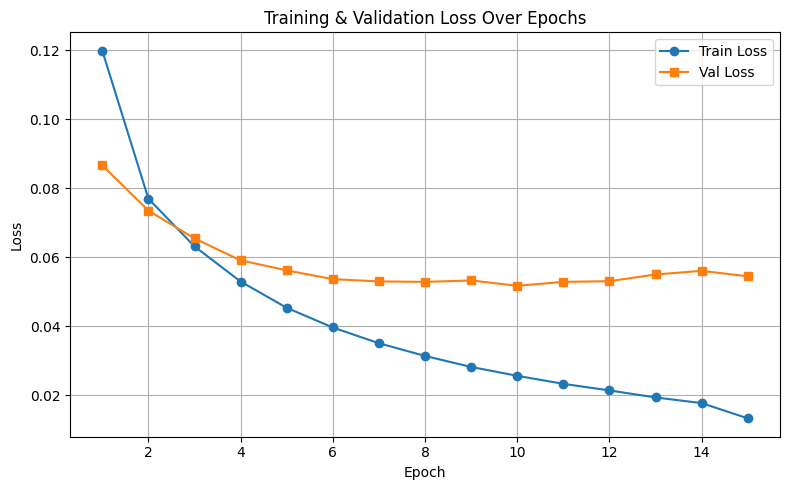

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from nn_model import EmbeddingClassifier

# Prepare feature matrix and labels
X_train = df_physionet_train.iloc[:, :ld].values  
X_test = df_physionet_test.iloc[:, :ld].values  
y_train = np.array(df_physionet_train['diagnostic'].tolist(), dtype=int)  
y_test = np.array(df_physionet_test['diagnostic'].tolist(), dtype=int)  

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # note: float for BCE loss
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Split into train and validation sets
val_ratio = 0.2
total_samples = X_train_tensor.size(0)
val_size = int(val_ratio * total_samples)
train_size = total_samples - val_size

train_dataset, val_dataset = random_split(
    TensorDataset(X_train_tensor, y_train_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Init model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = EmbeddingClassifier(input_dim=input_dim, output_dim=output_dim)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop
epochs = 15
train_losses = []
val_losses = []

print("🚀 Starting training...")
for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            output = model(xb)
            loss = criterion(output, yb)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"📉 Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Plot and save loss curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Val Loss')
plt.title("Training & Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("vae_train_val_loss.png")
print("📈 Saved training+validation loss plot as 'vae_train_val_loss.png'")


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Get probabilities from model
with torch.no_grad():
    logits = model(X_train_tensor)
    probs_val = torch.sigmoid(logits).cpu().numpy()

# Ground truth
y_train = y_train_tensor.cpu().numpy()

# Search for optimal thresholds (grid search over 0.0–1.0)
best_thresholds = []
for i in range(y_train.shape[1]):
    best_f1 = 0
    best_thresh = 0.5
    for t in np.linspace(0.1, 0.9, 17):  # test thresholds from 0.1 to 0.9
        preds = (probs_val[:, i] > t).astype(int)
        f1 = f1_score(y_train[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    best_thresholds.append(best_thresh)

best_thresholds = np.array(best_thresholds)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Put model in evaluation mode
model.eval()

# Get predictions
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    # Make sure best_thresholds is a torch tensor, same shape as probs
    thresholds_tensor = torch.tensor(best_thresholds, dtype=torch.float32).to(probs.device)

    # Apply thresholds with broadcasting
    y_pred = (probs > thresholds_tensor).int().cpu().numpy()
# Convert ground truth to numpy (if it's still a tensor)
y_true = y_test_tensor.cpu().numpy()

# Compute metrics
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
overall_accuracy = accuracy_score(y_true, y_pred)

# Generate classification report (per label)
class_report = classification_report(
    y_true, y_pred,
    target_names=[str(i) for i in range(y_true.shape[1])],
    zero_division=0
)

# Print results
print("✅ Overall Accuracy:", overall_accuracy)
print("✅ F1 Score (Macro):", f1_macro)
print("✅ F1 Score (Micro):", f1_micro)
print("✅ Classification Report:\n", class_report)

✅ Overall Accuracy: 0.29430604982206404
✅ F1 Score (Macro): 0.2343608589329397
✅ F1 Score (Micro): 0.42501562557446965
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.33      0.30       791
           1       0.40      0.38      0.39      1155
           2       0.28      0.02      0.03       272
           3       0.00      0.00      0.00         6
           4       0.57      0.23      0.32       124
           5       0.76      0.63      0.69       580
           6       0.37      0.22      0.28       319
           7       0.10      0.08      0.09       186
           8       0.38      0.35      0.36       740
           9       0.49      0.30      0.37       249
          10       0.00      0.00      0.00        30
          11       0.15      0.09      0.11       208
          12       0.07      0.03      0.04       222
          13       0.01      0.01      0.01       128
          14       0.56      0.58      0.57 

### Multiclass

For the multi-class prediction, i.e. the separation of the classes "sinus", "rbbb", "lbbb" and "avblock", we used the k-nearest neighbor classification. The hyperparameter $k$ was determined using the Medalcare validation dataset as a cross-validation set. The best result $k$ was then used to train the kNN classifier based on the Medalcare training dataset and on the Medalcare test dataset that had never been used before (i.e. it was never included in any training process, neither in the VAE nor in the kNN process).

In [ ]:
best_k = Helper.cross_validation_knn(X_train, X_test, y_train, y_test)

ValueError: 
All the 47 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
47 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\neighbors\_classification.py", line 239, in fit
    return self._fit(X, y)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\neighbors\_base.py", line 478, in _fit
    X, y = validate_data(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1387, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1397, in _check_y
    y = check_array(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\validation.py", line 104, in _assert_all_finite
    if _object_dtype_isnan(X).any():
  File "c:\Users\Thomas Kaprielian\Documents\Master's Thesis\VECG\venv\lib\site-packages\sklearn\utils\fixes.py", line 84, in _object_dtype_isnan
    return X != X
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [ ]:
plt.rcParams['font.size'] = 12

In [ ]:
plt.figure(figsize=(12,12))
cm, classes, predictions = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_multiclass_medalcare_diagnostic.png',
    dpi=DPI,
)

In [ ]:
Helper.calculate_f1(cm, include)

In [ ]:
Visualizations.print_metrics_multiclass(cm, y_test, predictions)

### Binary

As with multi-class prediction, the same approach was followed for binary classification, i.e. the "sinus" samples were separated from the "rbbb", "lbbb" and "avblock" classes.

In [ ]:
best_k = Helper.cross_validation_knn(X_train, X_val, y_train_b, y_val_b)

In [ ]:
cm, classes, predictions_b = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=best_k),
    '../analysis/media/confusion_matrix_binary_medalcare_diagnostic.png',
    dpi=DPI,
)

In [ ]:
Visualizations.print_metrics_binary(cm, y_test_b, predictions_b)

### Interpretation

Finally, we would like to use distribution diagrams to investigate how well the pathologies can be separated along the explainable axis.

In [ ]:
pair_df = df_medalcare_test[df_medalcare_test.diagnosis.isin(include)].loc[:, list([3, 4, 6, 10]) + ['diagnosis']]

In [ ]:
pair_df.diagnosis = pair_df.diagnosis.replace('sinus', 'Sinus').replace('rbbb', 'RBBB').replace('lbbb', 'LBBB').replace('avblock', 'AVBlock').replace('miLCX', 'MI LCX')

In [ ]:
cols = {'diagnosis': 'Diagnosis'}
pair_df = pair_df.rename(columns=cols)

In [ ]:
palette = {'Sinus': 'tab:orange', 'MI LCX': 'tab:blue', 'LBBB': 'tab:purple', 'RBBB': 'tab:green', 'AVBlock': 'tab:red'}

In [ ]:
plt.rcParams['font.size'] = 20
pairplot = sns.pairplot(pair_df, hue="Diagnosis", plot_kws={"s": 1}, diag_kws={'common_norm': False}, palette=palette, aspect=1.3)

for handle in pairplot._legend.legendHandles:
    handle.set_markersize(10)
sns.move_legend(pairplot, "upper center", bbox_to_anchor=(.45, 1.08), ncol=5, frameon=False)
for ax in pairplot.axes[:, 0]:
    ax.yaxis.set_label_coords(-0.3, 0.5)

pairplot.savefig('../analysis/media/anomaly_interpretation_medalcare.png', dpi=DPI)

## 3. Personalization

The subjects from the _icentia11k_ data set are used for personalization. For each of the 100 subjects randomly selected from the total dataset, the base model is fine-tuned and the embedding is saved. From the 100 randomly selected samples of the icentia11k dataset, a set of 6 subjects was selected for the analysis of the distribution graphs. 3 samples were selected because they contained a large number of PAC samples, while the other 3 samples were selected because of the frequent occurrence of PVC. All 6 samples also had a high number of normal class ECG beats. A custom color palette is defined for the classes Normal, PVC, and PAC to adhere to consisting coloring throughout the evaluation.

In [ ]:
from src.evaluate.personalization import fine_tune

In [ ]:
datasets = {
    'name': ['icentia11k'],
    'shuffle_size': 1024,
    'batch_size': 1024,
}

splits = [
    '107', '5484', '6998', '3984', '3111', '4040', '3013', '6607', '4219', '8750', '5665', '9225',
    '8030', '9886', '1851', '1123', '3043', '3369', '6829', '10969', '3088', '9405', '9535', '4993',
    '4209', '10937', '6167', '4688', '6877', '10733', '8412', '10146', '10973', '9345', '2514', '2908',
    '5938', '5015', '9595', '8769', '4786', '2602', '7779', '2826', '1118', '3485', '2980', '10503',
    '7719', '6575', '1722', '7234', '8366', '3948', '5493', '10731', '8111', '2820', '5337', '5369',
    '4184', '9403', '9625', '303', '33', '3274', '1941', '9116', '9283', '3522', '4836', '7107', '251',
    '9071', '6899', '9733', '9440', '457', '2954', '1839', '5865', '8500', '9559', '1277', '1145', '10107',
    '9287', '8443', '9783', '9956', '10090', '3204', '6814', '4553', '6377', '5572', '1178', '5032', '1793', '4453',
]

subjects = ['2602', '9225', '10973', '1851', '5938', '10146']
# use a custom order to stay consistent in the order of presentation
custom_sort_order = [2602, 9225, 10973, 1851, 5938, 10146]

palette = {'Normal': 'C0', 'PVC': 'C2', 'PAC': 'C1'}

ld = 12
path_save = '../analysis/personalization/embeddings_vae/'

In [ ]:
if not USE_PRECOMPUTED:
    fine_tune(path_model, datasets, splits, ld, path_save)

### Personlized Models: Accuracy

Let's load the emebddings from the personalzed computations and train a kNN on the train set (80 % of the complete dataset) and save the confusion matrix based on the test set (remaining 20 %).

In [ ]:
def plot_confustion_matrix(X_train, X_test, y_train, y_test, predictor, path, dpi, normalize=False, cmap='Greens'):
        predictor.fit(X_train.fillna(0), y_train)
        predictions = predictor.predict(X_test.fillna(0))
        cm = confusion_matrix(y_test, predictions, labels=predictor.classes_)
        return cm, predictor.classes_, predictions

In [ ]:
if not USE_PRECOMPUTED:
    for k in glob.glob('../analysis/personalization/embeddings_vae/*.csv'):
        try:
            df_pers = pd.read_csv(k)
            df_pers["beat_b"] = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'Anomal').replace(3.0, 'Anomal')
            df_pers.beat = df_pers.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
            df_pers = df_pers[df_pers.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
            
            X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat,
                    )
            cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
            pred_df = pd.DataFrame(cm, columns=classes, index=classes)
            pred_df.to_csv('../analysis/personalization/confusion_matrices/' + k.split('/')[-1])
            
            if df_pers.groupby('beat_b')['beat_b'].count()['Anomal'] > 500:
                X_train, X_test, y_train, y_test = train_test_split(
                        df_pers.iloc[:, :ld],
                        df_pers.beat_b,
                        test_size=0.2,
                        random_state=42,
                        stratify=df_pers.beat_b,
                    )
                cm, classes, prediction = plot_confustion_matrix(
                        X_train, X_test, y_train, y_test,
                        KNeighborsClassifier(n_neighbors=13),
                        '../analysis/media/test.png',
                        dpi=10,
                    )
                pred_df = pd.DataFrame(cm, columns=classes, index=classes)
                pred_df.to_csv('../analysis/personalization/confusion_matrices_b/' + k.split('/')[-1])
        except Exception as e:
            print('Skipped', e)
            continue

There are two ways to merge the confusion matrices to evaluate the overall goodness of fit. Therefore, we load the confusion matrices and:
1. sum them element by element and then normalize them per row
2. normalize them per subject and row and then sum them together

Both versions offer a different view of the matter. However, the latter (2) offers a more unbiased way to evaluate performance, as highly unbalanced class distributions are not as significant.

In [ ]:
df = pd.DataFrame()
df_unbiased = pd.DataFrame()
files = glob.glob('../analysis/personalization/confusion_matrices/*.csv')
files_b = glob.glob('../analysis/personalization/confusion_matrices_b/*.csv')
individual_f1_scores = []
index_and_columns = ['Normal', 'PAC', 'PVC']
index_and_columns_b = ['Normal', 'Anomal']

for i, k in enumerate(files):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns, columns=index_and_columns, fill_value=0)
    df = df.add(temp, fill_value=0)

for i, k in enumerate(files_b):
    temp = pd.read_csv(k, index_col=0)
    temp = temp.reindex(index=index_and_columns_b, columns=index_and_columns_b, fill_value=0)
    individual_f1_result = Helper.calculate_f1(temp.to_numpy(), temp.columns)
    individual_f1_scores.append(individual_f1_result)

In [ ]:
Helper.calculate_f1(df.to_numpy(), df.columns)

In [ ]:
avg_metrics_b = {
    'Macro F1': 0,
    'Precision': {'Normal': 0, 'Anomal': 0},
    'Recall': {'Normal': 0, 'Anomal': 0},
    'F1 Scores': {'Normal': 0, 'Anomal': 0},
}

In [ ]:
Helper.average_metrics(individual_f1_scores, avg_metrics_b)

### Personlized Models: Inter-subject patterns

We load the embedding (of the base model) of all subjects from the convenience sample and embed them in a 2-dimensional space using TSNE. Due to computational limitations, only a small portion (20%) of the total available data is used. However, the uniform subsample should capture the overall distribution well enough.

In [ ]:
if not USE_PRECOMPUTED:
    df = Helper.get_icentia_embedding(subjects, model)
    X_train, X_test, y_train, y_test = train_test_split(
            df,
            df.subject,
            test_size=0.2,
            random_state=42,
            stratify=df.subject,
        )
    
    X_embedded = TSNE(n_components=2).fit_transform(X_test.iloc[:,:ld].fillna(0.0))
    X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
    X_embedded['Beat'] = X_test.beat.values
    X_embedded['Subject'] = y_test.values
    X_embedded.to_csv('../analysis/personalization/embeddings_tsne/all.csv')
else:
    X_embedded = pd.read_csv('../analysis/personalization/embeddings_tsne/all.csv')

In [ ]:
df_melted = pd.melt(X_embedded, id_vars=['Projected Axis 1', 'Projected Axis 2'], 
                    value_vars=['Subject', 'Beat'], 
                    var_name='Color', value_name='Color_')

g = sns.FacetGrid(df_melted, col='Color', height=5, aspect=1)

g.map(sns.scatterplot, 'Projected Axis 1', 'Projected Axis 2', 'Color_', s=1, palette='tab10')

g.set_axis_labels("","")

for i, ax in enumerate(g.axes.flat):
    if i == 0:
        ax.set_yticks([-100, 0, 100])

plt.legend(markerscale=7, loc='upper left')
plt.tight_layout()
fig = g.figure
fig.savefig('../analysis/media/embedding_icentia.png' , dpi=DPI, bbox_inches = 'tight')

Since we have seen a strong clustering behavior with respect to the subjects, we would like to investigate the individual embeddings based on their personalized Mdoels. Therefore, we load the subjects' personalized embeddings and embed them individually (i.e., unlike in the previous calculation, all together but each one separately) into 2-dimensional points with TSNE.

In [ ]:
if not USE_PRECOMPUTED:
    for subject in subjects:
        print(subject)
        df = pd.read_csv('../analysis/personalization/embeddings_vae/' + str(subject) + '.csv', index_col=0)
        X_embedded = TSNE(n_components=2).fit_transform(df.iloc[:, 0:ld])
        X_embedded = pd.DataFrame(X_embedded, columns=['Projected Axis 1', 'Projected Axis 2'])
        X_embedded['beat'] = df.beat
        X_embedded['segment'] = df.segment
        X_embedded.beat = X_embedded.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
        X_embedded = X_embedded[X_embedded.beat != 'Unclassified']
        cols = {'beat': 'Beat'}
        X_embedded = X_embedded.rename(columns=cols)
        X_embedded.to_csv('../analysis/personalization/embeddings_tsne_small/' + str(subject) + '.csv')

In [ ]:
df = pd.DataFrame()
for path in glob.glob('../analysis/personalization/embeddings_tsne_small/*.csv'):
    subject = path.split('/')[-1][:-4]
    if subject != 'all':
        X_embedded = pd.read_csv(path, index_col=0)
        X_embedded['subject'] = subject
        df = pd.concat([df, X_embedded])
df.reset_index(drop=True, inplace=True)
cols = {'subject': 'Subject'}
df = df.rename(columns=cols)
df.Subject = df.Subject.astype(int)
df['Subject'] = pd.Categorical(df['Subject'], categories=custom_sort_order, ordered=True)

In [ ]:
g = sns.FacetGrid(df, col="Subject", col_wrap=3, palette=palette, hue="Beat", sharex=True, sharey=False)
g.map(sns.scatterplot, "Projected Axis 1", "Projected Axis 2", s=1)
g.set_axis_labels("", "")

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i % 3 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

g.fig.subplots_adjust(wspace=0.1, hspace=0.01)

handles, labels = g.axes[0].get_legend_handles_labels()
sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, markerscale=7, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, borderaxespad=0., edgecolor='white')

plt.tight_layout()
fig = g.figure

fig.savefig('../analysis/media/tsne_embedding_personalization.png', dpi=DPI, bbox_inches='tight')

### Personalized Models: Explainability Pathologies along the axis

For this experiment, we reload the embeddings of the personalized models. We expect a separating behavior on the fourth dimension, which is related to the S-wave, the Q-wave and thus the width of the QRS complex, one of the most important morphological changes in PVC. The same applies to the P wave and the PAC. The convincingly selected subjects who had either a high number (for significance) of PAC or PVCs were used to create the diagram. 

In [ ]:
df_pers = pd.DataFrame()
for k in subjects:
    df_per = pd.read_csv('../analysis/personalization/embeddings_vae_small/' + k + '.csv')
    df_per.beat = df_per.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
    df_per = df_per[df_per.beat != 'Unclassified'].drop('Unnamed: 0', axis=1)
    df_pers = pd.concat([df_pers, df_per])
df_pers.reset_index(drop=True, inplace=True)
cols = {
    'split': 'Subject', 'beat': 'Beat', #'4': 'S-wave and Q-Wave (width)', '5': 'P-wave (height, width)', 
}
df_pers = df_pers.rename(columns=cols)
df_pers.Subject = df_pers.Subject.astype(int)
df_pers.reset_index(drop=True, inplace=True)

In [ ]:
df_pers_pac = df_pers[df_pers.Subject.isin([2602, 9225, 10973])]
df_pers_pvc = df_pers[df_pers.Subject.isin([1851, 5938, 10146])]

In [ ]:
df_pers_pac = df_pers_pac.sort_values('Subject')
df_pers_pvc = df_pers_pvc.sort_values('Subject')

In [ ]:
g = sns.FacetGrid(df_pers_pac, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "1", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 1', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

fig = g.fig
fig.savefig('../analysis/media/distribution_pac.png', dpi=DPI, bbox_inches='tight')

In [ ]:
g = sns.FacetGrid(df_pers_pvc, col="Subject", col_wrap=3, hue="Beat", palette=palette, sharey=False, aspect=1)
g.map(sns.kdeplot, "4", common_norm=False, warn_singular=False)

handles, labels = g.axes[0].get_legend_handles_labels()

for i, ax in enumerate(g.axes):
    ax.set_xlabel('')
    if i == 0:
        ax.set_yticklabels([])
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', which='both', left=False) 

sorted_handles_labels = sorted(zip(handles, labels), key=lambda x: x[1])
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

g.fig.legend(sorted_handles, sorted_labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3, borderaxespad=0., edgecolor='white')
g.fig.text(0.5, 0.1, 'Dimension 4', ha='center')
g.fig.subplots_adjust(wspace=0.1)
plt.show()

# Save the figure
fig = g.fig
fig.savefig('../analysis/media/distribution_pvc.png', dpi=DPI, bbox_inches='tight')

Finally, for all subjects and all axis, the distribution plot is generated. Note, that for several subjects there is a strong class imbalance.

In [ ]:
for i, k in enumerate(df_pers.columns[:ld]):
    g = sns.FacetGrid(df_pers, col="Subject", col_wrap=9, hue="Beat", sharey=False, palette=palette)
    g.map(sns.kdeplot, k, common_norm=False, warn_singular=False)
    plt.legend()
    fig = g.figure
    fig.savefig('../analysis/media/distribution_personalization_all_' + str(i) + '.png' , dpi=300, bbox_inches = 'tight')